In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
import xgboost as xgb

In [2]:
from sklearn.linear_model import (LinearRegression, LassoCV, RidgeCV, Lasso, Ridge )
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, Normalizer)
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
from sklearn.linear_model import (ElasticNet, ElasticNetCV)
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV

## 1. Загрузить данные day.csv

In [3]:
# url = 'https://archive.ics.uci.edu/ml/datasets/Bike%20Sharing%20Dataset'
bike = pd.read_csv('day.csv')
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
bike.drop('instant', axis=1, inplace=True)

In [5]:
bike.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## 2.Сделать предварительный анализ данных: шкалы измерения, типы данных, корреляцию и т.п.

Только нужные признаки

In [6]:
bike[['season', 'weekday', 'temp', 'atemp', 'weathersit', 'hum', 'windspeed', 'casual', 'registered']].describe()

,season,weekday,temp,atemp,weathersit,hum,windspeed,casual,registered
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,2.997264,0.495385,0.474354,1.395349,0.627894,0.190486,848.176471,3656.172367
std,1.110807,2.004787,0.183051,0.162961,0.544894,0.142429,0.077498,686.622488,1560.256377
min,1.000000,0.000000,0.059130,0.079070,1.000000,0.000000,0.022392,2.000000,20.000000
25%,2.000000,1.000000,0.337083,0.337842,1.000000,0.520000,0.134950,315.500000,2497.000000
50%,3.000000,3.000000,0.498333,0.486733,1.000000,0.626667,0.180975,713.000000,3662.000000
75%,3.000000,5.000000,0.655417,0.608602,2.000000,0.730209,0.233214,1096.000000,4776.500000
max,4.000000,6.000000,0.861667,0.840896,3.000000,0.972500,0.507463,3410.000000,6946.000000


In [7]:
bike.info()
# Пустых значений нет
# Все данные числовые, кроме столбца (dteday)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      731 non-null    object 
 1   season      731 non-null    int64  
 2   yr          731 non-null    int64  
 3   mnth        731 non-null    int64  
 4   holiday     731 non-null    int64  
 5   weekday     731 non-null    int64  
 6   workingday  731 non-null    int64  
 7   weathersit  731 non-null    int64  
 8   temp        731 non-null    float64
 9   atemp       731 non-null    float64
 10  hum         731 non-null    float64
 11  windspeed   731 non-null    float64
 12  casual      731 non-null    int64  
 13  registered  731 non-null    int64  
 14  cnt         731 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 85.8+ KB


In [8]:
pd.DataFrame(bike.season.value_counts())

,season
3,188
2,184
1,181
4,178


In [9]:
for col in bike.columns:
    display(pd.DataFrame(bike[col].value_counts()))

,dteday
2012-06-27,1
2011-08-14,1
2011-10-26,1
2011-06-01,1
2012-02-05,1
...,...
2012-03-29,1
2012-04-22,1
2012-02-06,1
2012-11-27,1


,season
3,188
2,184
1,181
4,178


,yr
1,366
0,365


,mnth
12,62
10,62
8,62
7,62
5,62
3,62
1,62
11,60
9,60
6,60


,holiday
0,710
1,21


,weekday
6,105
1,105
0,105
5,104
4,104
3,104
2,104


,workingday
1,500
0,231


,weathersit
1,463
2,247
3,21


,temp
0.265833,5
0.635000,5
0.437500,4
0.564167,4
0.649167,4
...,...
0.226957,1
0.354167,1
0.580833,1
0.231667,1


,atemp
0.654688,4
0.637008,3
0.375621,3
0.542929,2
0.603554,2
...,...
0.612379,1
0.464021,1
0.624371,1
0.512621,1


,hum
0.613333,4
0.568333,3
0.542500,3
0.752917,3
0.697083,3
...,...
0.615000,1
0.686667,1
0.480833,1
0.649565,1


,windspeed
0.228858,3
0.118792,3
0.134954,3
0.149883,3
0.166667,3
...,...
0.388067,1
0.185333,1
0.189667,1
0.290421,1


,casual
968,4
120,4
244,3
653,3
639,3
...,...
614,1
1639,1
616,1
620,1


,registered
4841,3
1707,3
6248,3
3578,2
4429,2
...,...
2720,1
670,1
1693,1
4763,1


,cnt
5119,2
4401,2
1977,2
6824,2
5191,2
...,...
6273,1
5501,1
4760,1
1683,1


Text(0.5, 1.0, 'Holiday')

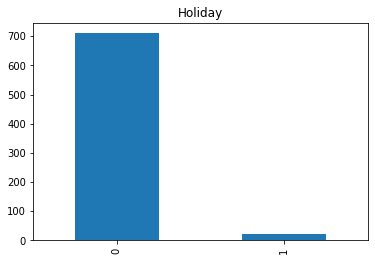

In [10]:
bike.holiday.value_counts().plot(kind='bar')
plt.title("Holiday")

Text(0.5, 1.0, 'Рабочий день')

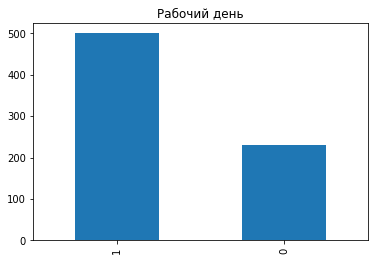

In [11]:
bike.workingday.value_counts().plot(kind='bar')
plt.title('Рабочий день')

Text(0.5, 1.0, 'Погода')

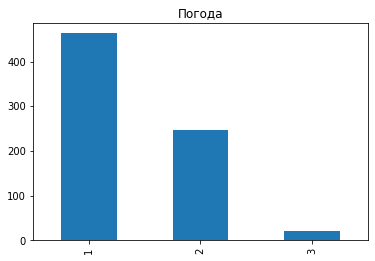

In [12]:
bike.weathersit.value_counts().plot(kind='bar')
plt.title('Погода')

Text(0.5, 1.0, 'season')

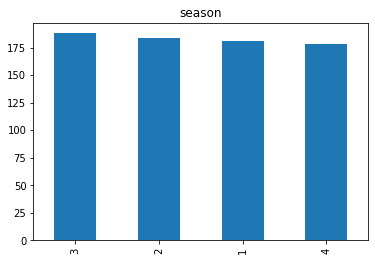

In [13]:
bike.season.value_counts().plot(kind='bar')
plt.title('season')

Text(0.5, 1.0, 'Month')

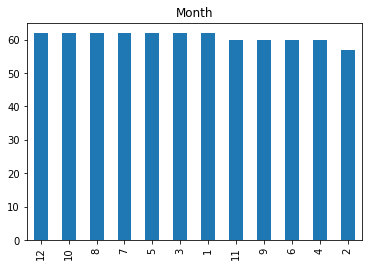

In [14]:
bike.mnth.value_counts().plot(kind='bar')
plt.title('Month')

<AxesSubplot:>

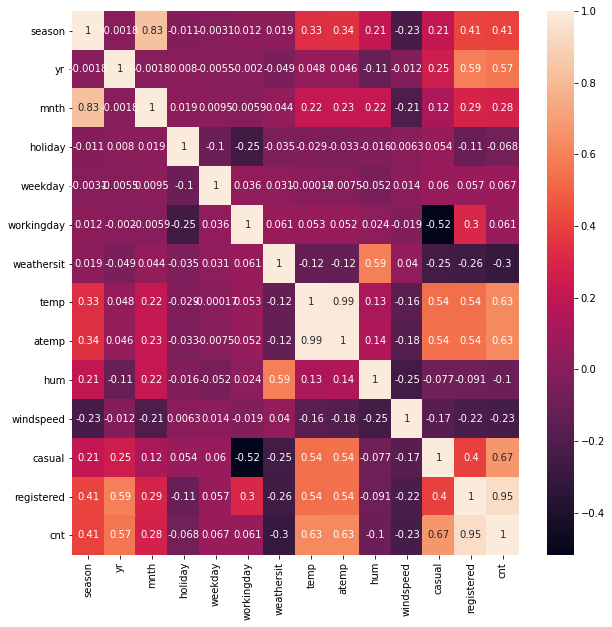

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(bike.corr(), annot=True, fmt='.2g', ax=ax)

## 3. Визуализировать данные

<AxesSubplot:xlabel='season', ylabel='cnt'>

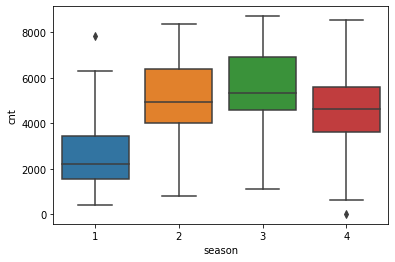

In [16]:
sns.boxplot(x='season', y='cnt', data=bike)

In [17]:
# sns.pairplot(data=bike)

## 4. X – все кроме cnt, y - cnt

Убираю:

- dteday - безполезный признак

- mnth - сильно коррелирует с season, а с cnt коррелирует меньше

- yr - не понятно по какой причине сильно коррелирует с целевой функцией cnt, хотя всего 2 значения. Уберу пожалуй

- temp - очень сильно коррелирует с atemp. Одинаково коррелируют с cnt

- casual: так как он вместе c registered образует cnt. Но 'registered' лучше коррелирует с 'cnt'

In [18]:
X = bike.drop('cnt', axis=1).copy()
y = bike['cnt'].copy()

In [19]:
X.drop(['dteday', 'yr', 'temp', 'casual'], axis=1, inplace=True) ##--работает лучше на 10 велосипедов
# X.drop(['dteday', 'mnth', 'yr', 'temp', 'casual'], axis=1, inplace=True)

# OneHotEncoder

In [20]:
X = pd.get_dummies(X, columns=['season', 'mnth','weekday', 'weathersit']) ##-- работает лучше на 10 велосипедов
# X = pd.get_dummies(X, columns=['season', 'weekday', 'weathersit'])
X.head()

,holiday,workingday,atemp,hum,windspeed,registered,season_1,season_2,season_3,season_4,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,0,0,0.363625,0.805833,0.160446,654,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,0,0.353739,0.696087,0.248539,670,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0,1,0.189405,0.437273,0.248309,1229,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0,1,0.212122,0.590435,0.160296,1454,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0,1,0.229270,0.436957,0.186900,1518,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


## 5. Разбить выборку в соотношении 70 на 30 (%) 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
X_train.shape, X_test.shape

((511, 32), (220, 32))

## 6. Провести стандартизацию X

### Проведем MinMaxScaling только для одного признака 'registered'

In [23]:
def minmaxscaling_transform(X, features):
    X_new = X.copy()
    for col in X[features]:
        min_val = X[col].min()
        max_val = X[col].max()
        X_new[col] = X[col].apply(lambda x: (x - min_val)/(max_val-min_val))
    return X_new

In [24]:
X_train.columns

Index(['holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'registered',
       'season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'mnth_10', 'mnth_11', 'mnth_12', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1',
       'weathersit_2', 'weathersit_3'],
      dtype='object')

In [25]:
X_train_scaled = minmaxscaling_transform(X_train, ['registered'])

In [26]:
X_test_scaled = minmaxscaling_transform(X_test, ['registered'])

In [27]:
X_train_scaled.head()

,holiday,workingday,atemp,hum,windspeed,registered,season_1,season_2,season_3,season_4,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
223,0,1,0.654042,0.415000,0.125621,0.526493,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
684,0,1,0.324492,0.620417,0.152987,0.721133,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
685,0,1,0.347204,0.524583,0.171025,0.734763,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
163,0,1,0.601654,0.494583,0.305350,0.572894,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
394,0,1,0.262625,0.400833,0.215792,0.471975,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [28]:
# ## Масштабирование
# scaler = StandardScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [29]:
# pd.DataFrame(X_train_scaled, columns=X.columns)

In [30]:
# ## Масштабирование
# scaler_1 = StandardScaler().fit(X)
# X_scaled = scaler_1.transform(X)
# X_scaled = scaler_1.transform(X)

In [31]:
X_scaled = minmaxscaling_transform(X, ['registered'])

In [32]:
%%time
alphas = np.linspace(0.01, 1, 10)
alpha_scores = dict()
for i, alpha in enumerate(alphas):
    cvs = cross_val_score(Lasso(alpha=alpha), X_scaled, y, cv=10, scoring='neg_mean_absolute_error')
    alpha_scores[alpha] = -cvs.mean()
best_alpha = min(alpha_scores, key=alpha_scores.get)
alpha_scores

Wall time: 1.78 s


{0.01: 284.30860906005194,
 0.12: 283.49784680696314,
 0.23: 282.7037473256032,
 0.34: 282.03969137576314,
 0.45: 281.419505763539,
 0.56: 280.72644017182677,
 0.67: 280.2297435009626,
 0.78: 279.9544392787241,
 0.89: 279.6655406397397,
 1.0: 279.3632682048681}

# Lasso

In [33]:
lasso = Lasso(alpha=best_alpha, random_state=42)
lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)
mean_absolute_error(y_test, y_pred)

312.6317808787946

In [34]:
def stat(model, X):
    display(pd.DataFrame(np.append(model.intercept_, model.coef_).reshape(1, -1), 
                         columns=np.append('intercept_', np.array(X.columns))))
stat(lasso, X)

,intercept_,holiday,workingday,atemp,hum,windspeed,registered,season_1,season_2,season_3,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,767.818458,-0.0,-706.394823,1274.159437,-272.375978,-565.567726,7533.880558,-0.0,117.727734,0.0,...,193.403923,0.0,-66.533196,-90.269833,-55.719037,117.99797,312.785654,97.026214,-0.0,-53.754133


In [35]:
y_test[:10]

703    6606
33     1550
300    3747
456    6041
633    7538
557    7264
39     1605
356    2209
559    7499
514    5743
Name: cnt, dtype: int64

In [36]:
y_pred.reshape(1, -1)[0][:10]

array([6766.29708608, 1510.70410026, 3949.55656738, 5469.8504489 ,
       7805.21268017, 7478.81916403, 1439.9118345 , 2494.90832946,
       7364.03470598, 6131.0843424 ])

# Linear Regression

In [38]:
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

y_pred = linreg.predict(X_test_scaled)

mean_absolute_error(y_test, y_pred)

312.9818181818182

# Ridge

In [39]:
ridge = Ridge(alpha=0.9)
ridge.fit(X_train_scaled, y_train)

y_pred = ridge.predict(X_test_scaled)

mean_absolute_error(y_test, y_pred)

324.3167128873539

# Random Forest

In [40]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X_train_scaled, y_train)

y_pred = random_forest.predict(X_test_scaled)

mean_absolute_error(y_test, y_pred)

315.28249999999997

# XGBoost

In [41]:
%%time
xgboost = xgb.XGBRegressor(objective="reg:squarederror", missing=None, seed=42, learning_rate=0.1, max_depth=5)
xgboost.fit(X_train_scaled, 
            y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='mae',
            eval_set=[(X_test_scaled, y_test)]
           )

[0]	validation_0-mae:3921.13696
Will train until validation_0-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:3511.28784
[2]	validation_0-mae:3146.02734
[3]	validation_0-mae:2818.15918
[4]	validation_0-mae:2518.72217
[5]	validation_0-mae:2254.16968
[6]	validation_0-mae:2011.97742
[7]	validation_0-mae:1793.88562
[8]	validation_0-mae:1598.56934
[9]	validation_0-mae:1421.91479
[10]	validation_0-mae:1261.52136
[11]	validation_0-mae:1118.99731
[12]	validation_0-mae:993.94928
[13]	validation_0-mae:880.50665
[14]	validation_0-mae:782.70868
[15]	validation_0-mae:698.97259
[16]	validation_0-mae:625.49707
[17]	validation_0-mae:561.61469
[18]	validation_0-mae:506.71985
[19]	validation_0-mae:459.74500
[20]	validation_0-mae:422.20575
[21]	validation_0-mae:388.66318
[22]	validation_0-mae:360.41431
[23]	validation_0-mae:337.18195
[24]	validation_0-mae:319.91757
[25]	validation_0-mae:305.84802
[26]	validation_0-mae:293.84680
[27]	validation_0-mae:285.59378
[28]	validation_0-mae:279.07260
[29]	v

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [42]:
y_pred = xgboost.predict(X_test_scaled)
mean_absolute_error(y_test, y_pred)

265.9208712491122

In [43]:
y_pred_train = xgboost.predict(X_train_scaled)
mean_absolute_error(y_train, y_pred_train)

156.7736396565596

# GridSearchCV

In [44]:
%%time
## Round 1
param_grid = {
    'objective': ['reg:squarederror', 'reg:squaredlogerror', 'reg:pseudohubererror'],
    'max_depth' : [3,4,5],
    'learning_rate':[0.5, 0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1,3,5]
}


optimal_params = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror',
                               seed=42,
                               subsample=0.9,
                               colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    verbose=0,
    n_jobs=-1,
    cv=3
)

optimal_params.fit(X_train_scaled,
                  y_train,
                  verbose=False,
                  early_stopping_rounds=10,
                  eval_metric='mae',
                  eval_set=[(X_test_scaled, y_test)])

Wall time: 27.7 s


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.5,
                                    gamma=None, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=N...
                                    scale_pos_weight=None, seed=42,
                                    subsample=0.9, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.25, 1.0],
  

In [45]:
optimal_params.best_score_

-321.06467088004507

In [46]:
optimal_params.best_params_

{'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'objective': 'reg:squarederror',
 'reg_lambda': 0,
 'scale_pos_weight': 1}

In [47]:
xgb_best = xgb.XGBRegressor(objective="reg:squarederror", 
                        missing=None, 
                        seed=42, 
                        learning_rate=0.1, 
                        max_depth=3,
                       gamma=0,
                       reg_lambda=0,
                       scale_pos_weight=1)
xgb_best.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [48]:
mean_absolute_error(y_test, xgb_best.predict(X_test_scaled))

288.1429579301314

In [49]:
mean_absolute_error(y_train, xgb_best.predict(X_train_scaled))

126.1573338219331

# Tensorflow

In [50]:
X_scaled_bias = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled]

In [51]:
m, n = X_scaled_bias.shape

In [60]:
y = np.array(y)

In [61]:
n_epochs = 10
learning_rate = 0.1

# X = tf.placeholder(tf.float32, shape=(None, n), name="X")
# y_tf = tf.placeholder(tf.float32, shape=(None, 1), name="y_tf")
X_tf = tf.constant(X_scaled_bias, dtype=tf.float32, name="X_tf")
y_tf = tf.constant(y.reshape(-1, 1), dtype=tf.float32, name="y_tf")

theta = tf.Variable(tf.random_uniform([n, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X_tf, theta, name="predictions")
error = y_pred - y_tf
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [62]:
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Best theta:
[[ 1829.721    ]
 [   32.10333  ]
 [  540.33636  ]
 [ 1616.516    ]
 [  961.4309   ]
 [  173.24829  ]
 [ 3067.453    ]
 [-1142.478    ]
 [  921.9164   ]
 [ 1291.7429   ]
 [  756.4206   ]
 [ -565.3826   ]
 [ -349.42664  ]
 [   -3.2383957]
 [   97.00552  ]
 [  456.73688  ]
 [  552.08826  ]
 [  354.76895  ]
 [  428.5112   ]
 [  602.7056   ]
 [  501.99344  ]
 [   -9.339419 ]
 [ -237.0947   ]
 [  468.41617  ]
 [    8.842518 ]
 [   59.998886 ]
 [   82.774994 ]
 [  172.16864  ]
 [  245.73294  ]
 [  789.50885  ]
 [ 1693.3989   ]
 [  502.47678  ]
 [ -367.03513  ]]


In [63]:
display(pd.DataFrame(best_theta.reshape(1, -1)[0], 
                         index=np.append('intercept_', X_scaled.columns)))

,0
intercept_,1829.720947
holiday,32.103329
workingday,540.336365
atemp,1616.515991
hum,961.430908
windspeed,173.248291
registered,3067.452881
season_1,-1142.478027
season_2,921.916382
season_3,1291.742920


In [64]:
y_pred = X_scaled_bias.dot(best_theta)

In [65]:
mean_absolute_error(y, y_pred.reshape(1, -1)[0])

2832.364001791608

# Neural Network

In [73]:
# len(X_train_scaled)

# feature_cols = []
# for feature_name in X_train_scaled.columns:
#     feature_cols.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))


# feature_cols

# dnn_reg = tf.estimator.DNNLinearCombinedRegressor(dnn_feature_columns=100, dnn_feature_columns=feature_cols)

# dnn_clf = tf.estimator.DNNClassifier(hidden_units=[300,100], n_classes=5, feature_columns=feature_cols)

# def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
#     def input_function():
#         ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
#         if shuffle:
#             ds = ds.shuffle(1000)
#         ds = ds.batch(batch_size).repeat(num_epochs)
#         return ds
#     return input_function

# train_input_fn = make_input_fn(X_train_scaled, y_train)

# train_input_fn

# dnn_reg.train(input_fn=train_input_fn)

# input_fn = tf.estimator.inputs.numpy_input_fn(
#     x=dict(X_train_scaled), y=y_train, num_epochs=40, batch_size=50, shuffle=True)
# dnn_clf.train(input_fn=input_fn)

# dnn_clf.train(input_fn=train_input_fn)

511

# Graphics

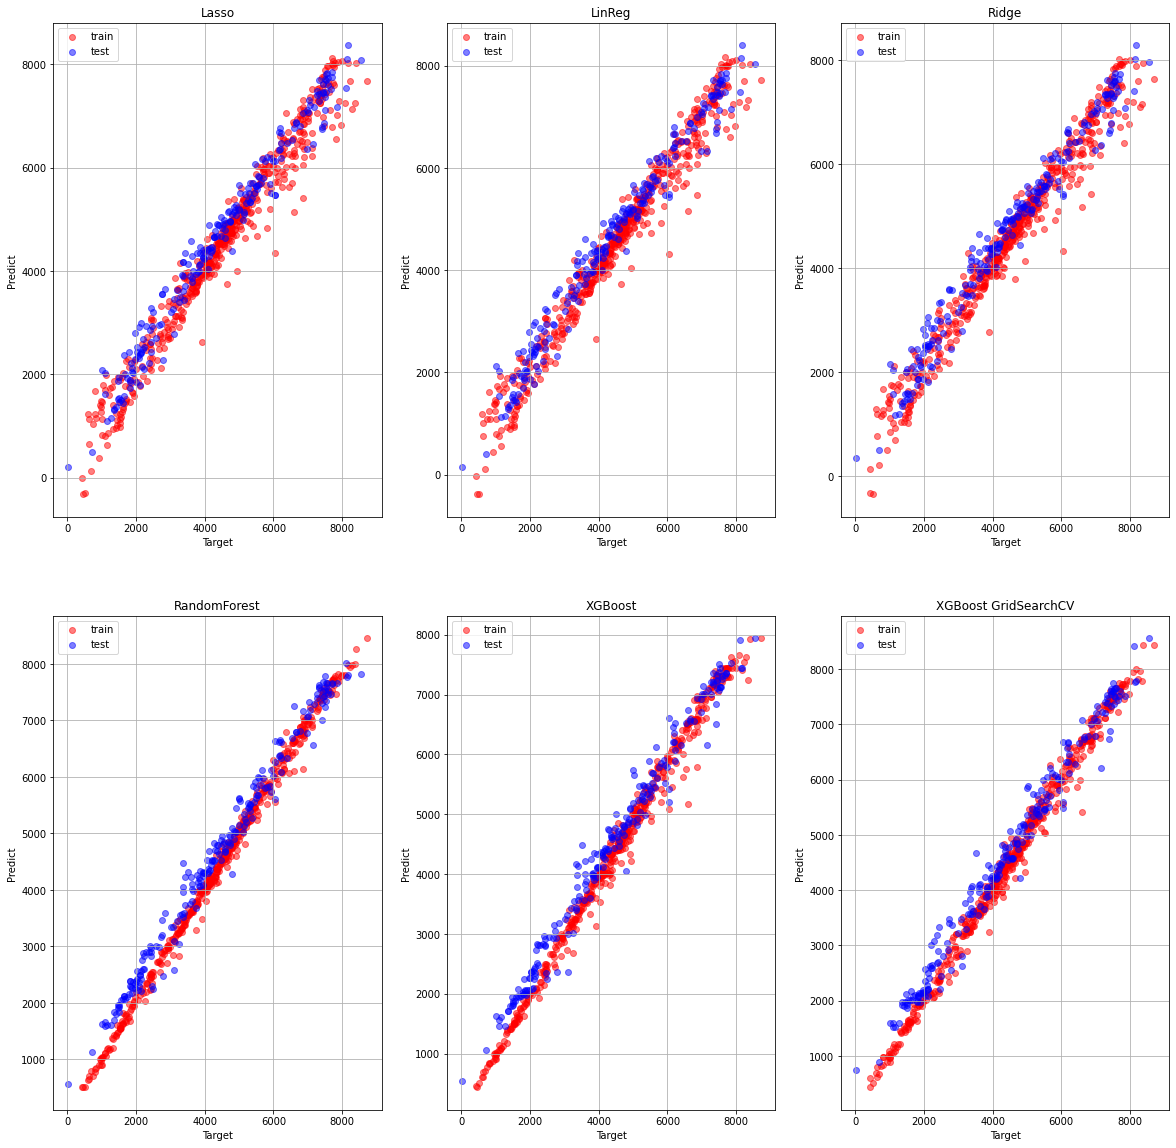

In [59]:
plt.figure(figsize=(20,20))
plt.subplot(2, 3, 1)
plt.scatter(y_train, lasso.predict(X_train_scaled), alpha=0.5, color='red', label='train')
plt.scatter(y_test, lasso.predict(X_test_scaled), alpha=0.5, color='blue', label='test')
plt.xlabel('Target')
plt.ylabel('Predict')
plt.title('Lasso')
plt.grid(True)
plt.legend()

plt.subplot(2, 3, 2)
plt.scatter(y_train, linreg.predict(X_train_scaled), alpha=0.5, color='red', label='train')
plt.scatter(y_test, linreg.predict(X_test_scaled), alpha=0.5, color='blue', label='test')
plt.xlabel('Target')
plt.ylabel('Predict')
plt.title('LinReg')
plt.grid(True)
plt.legend()


plt.subplot(2, 3, 3)
plt.scatter(y_train, ridge.predict(X_train_scaled), alpha=0.5, color='red', label='train')
plt.scatter(y_test, ridge.predict(X_test_scaled), alpha=0.5, color='blue', label='test')
plt.xlabel('Target')
plt.ylabel('Predict')
plt.title('Ridge')
plt.grid(True)
plt.legend()

plt.subplot(2, 3, 4)
plt.scatter(y_train, random_forest.predict(X_train_scaled), alpha=0.5, color='red', label='train')
plt.scatter(y_test, random_forest.predict(X_test_scaled), alpha=0.5, color='blue', label='test')
plt.xlabel('Target')
plt.ylabel('Predict')
plt.title('RandomForest')
plt.grid(True)
plt.legend()

plt.subplot(2, 3, 5)
plt.scatter(y_train, xgboost.predict(X_train_scaled), alpha=0.5, color='red', label='train')
plt.scatter(y_test, xgboost.predict(X_test_scaled), alpha=0.5, color='blue', label='test')
plt.xlabel('Target')
plt.ylabel('Predict')
plt.title('XGBoost')
plt.grid(True)
plt.legend()

plt.subplot(2, 3, 6)
plt.scatter(y_train, xgb_best.predict(X_train_scaled), alpha=0.5, color='red', label='train')
plt.scatter(y_test, xgb_best.predict(X_test_scaled), alpha=0.5, color='blue', label='test')
plt.xlabel('Target')
plt.ylabel('Predict')
plt.title('XGBoost GridSearchCV')
plt.grid(True)
plt.legend()

## Чем прямее линия - тем лучше наша модель

## 7. Написать функцию обучения модели и вывода RMSE, coef, R^2

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

In [ ]:
def train_validate_report(model, X_train, X_test, y_train, y_test, feature_names, X_scaled:bool,
                          model_name=None, verbose=True):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    coefs = {'intercept': l.intercept_, **dict(zip(feature_names, model.coef_))}
    coefs_df = pd.DataFrame.from_dict({'value': coefs})
    
    if verbose:
        if model_name:
            if X_scaled: model_name += '(scaled)'
            print(f'##### {model_name} ####')
        print(f'RMSE = {rmse}')
        print(f'R^2 = {r2}')
        print(coefs_df)
        print()
    
    return rmse, r2, coefs, model
    
    
    

In [ ]:
def train_validate_report(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    coefs = pd.DataFrame(np.append(model.intercept_, model.coef_).reshape(1, -1), 
                         columns=np.append('intercept_', np.array(X.columns)))
    #coefs = {'intercept': l.intercept_, **dict(zip(feature_names, model.coef_))}
    
    print("Model:", model)
    print("\tRMSE:", rmse)
    print("\tR^2:", r2)
    display(coefs)
#     if verbose:
#         if model_name:
#             if X_scaled: model_name += '(scaled)'
#             print(f'##### {model_name} ####')
#         print(f'RMSE = {rmse}')
#         print(f'R^2 = {r2}')
#         print(coefs_df)
#         print()
    
#     return rmse, r2, coefs, model